#Modules

In [3]:
!pip install mplfinance


In [4]:
pip install arch

In [5]:
!pip install livelossplot


In [6]:
pip install mpld3


In [7]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins
%matplotlib inline
import seaborn as sns
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import math
#For the LSTM task
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKerasTF
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")


In [8]:
mpld3.enable_notebook()

#Loading of datasets

In [9]:
df_eth = pd.read_csv("ETH-USD.csv",parse_dates=True)
df_xrp = pd.read_csv("xrp.csv",parse_dates=True)
df_iota=pd.read_csv("IOTA.csv", parse_dates=True)
df_doge=pd.read_csv("dogecoin.csv", parse_dates=True)
df_lite=pd.read_csv("litecoin.csv", parse_dates=True)

#Data Setting

I want to analyse the cryptocurrencies datasets in the same period of time, so I delete some rows.

In [10]:
def data_setting(df):
  df['Date']=pd.to_datetime(df['Date'])
  df=df[~(df['Date']<'2017-11-09')]
  df=df[~(df['Date']>'2021-08-26')]
  return df

In [11]:
df_eth=data_setting(df_eth) 
df_xrp=data_setting(df_xrp)
df_iota=data_setting(df_iota)
df_doge=data_setting(df_doge)
df_lite=data_setting(df_lite)

#Calculation

In [12]:
def volatility_calculation(df):
  df['log_price'] = np.log(df['Close']) #Firstly we should take the logarithmic return from prices
  df['pct_change'] = df['log_price'].diff() #after that let's take difference
  df['stdev'] = df['pct_change'].rolling(window=30, center=False).std()
  df['Volatility'] = df['stdev'] * (365**0.5) # Annualize.
  return df

In [13]:
df_eth=volatility_calculation(df_eth)
df_xrp=volatility_calculation(df_xrp)

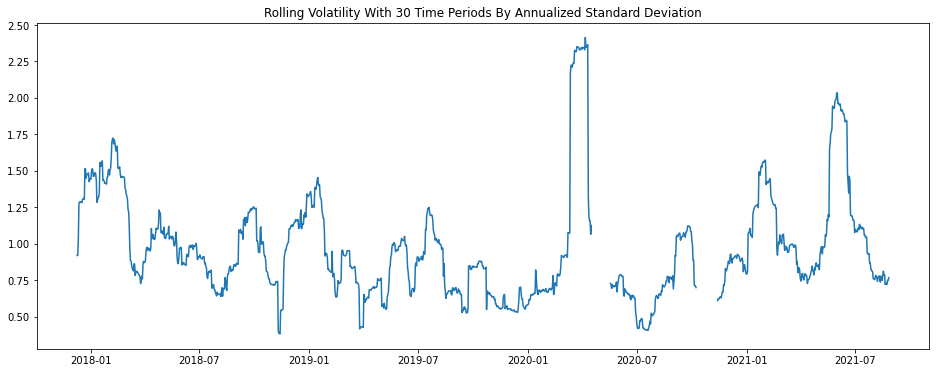

In [14]:
plt.figure(figsize=(16,6))
plt.plot(df_eth['Date'], df_eth['Volatility'])
plt.title("Rolling Volatility With 30 Time Periods By Annualized Standard Deviation")
plt.show()

 $$\sigma^2(t) = \alpha \times \sigma^2(t-1) + \beta \times e^2(t-1) + w$$


#Drop of Columns and NaN rows

In [15]:
df_eth = df_eth.drop(columns=['Adj Close'])
df_eth=df_xrp.drop(['Currency'], axis=1)
df_xrp=df_xrp.drop(['Currency'], axis=1)
df_iota=df_iota.drop(['Currency'], axis=1)
df_doge=df_doge.drop(['Currency'], axis=1)
df_lite=df_lite.drop(['Currency'], axis=1)

In [16]:
print(df_eth.shape)
print(df_xrp.shape)
print(df_iota.shape)
print(df_doge.shape)
print(df_lite.shape)

(1387, 10)
(1387, 10)
(1387, 6)
(1387, 6)
(1387, 6)


In [17]:
df_eth.dropna(inplace=True)
df_xrp.dropna(inplace=True)
df_iota.dropna(inplace=True)
df_doge.dropna(inplace=True)
df_lite.dropna(inplace=True)

In [18]:
print(df_eth.shape)
print(df_xrp.shape)
print(df_iota.shape)
print(df_doge.shape)
print(df_lite.shape)

(1357, 10)
(1357, 10)
(1387, 6)
(1387, 6)
(1387, 6)


In [19]:
(df_eth.shape[0]/3)*2

904.6666666666666

#Volatility Predictions

$$\sum{\sqrt{(\hat{X_i}-X_i)^2}/T}$$


In [30]:
def rmse_tr(predictions, targets): 
  return np.sqrt(((targets - predictions) ** 2).mean())



Iteration:      1,   Func. Count:      7,   Neg. LLF: 872.4887845750864
Iteration:      2,   Func. Count:     23,   Neg. LLF: 539.9273508721421
Iteration:      3,   Func. Count:     32,   Neg. LLF: 397.77220551356913
Iteration:      4,   Func. Count:     40,   Neg. LLF: 347.10530280304056
Iteration:      5,   Func. Count:     48,   Neg. LLF: 318.2968962410472
Iteration:      6,   Func. Count:     56,   Neg. LLF: 293.39698476406454
Iteration:      7,   Func. Count:     64,   Neg. LLF: 270.9022411443941
Iteration:      8,   Func. Count:     72,   Neg. LLF: 256.0607419581926
Iteration:      9,   Func. Count:     80,   Neg. LLF: 236.76499247182042
Iteration:     10,   Func. Count:     87,   Neg. LLF: 165.4438489234995
Iteration:     11,   Func. Count:     95,   Neg. LLF: 143.53073061044088
Iteration:     12,   Func. Count:    103,   Neg. LLF: 139.60637085457395
Iteration:     13,   Func. Count:    112,   Neg. LLF: 138.00165524383962
Iteration:     14,   Func. Count:    119,   Neg. LLF: 133

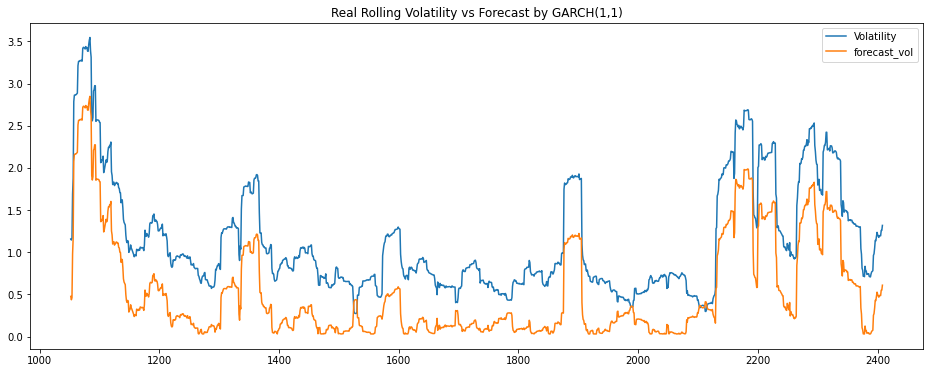

Root Mean Squared Error of the GARCH(1,1) model is calculated as  0.6222032424652556


In [21]:
from arch import arch_model
from arch.univariate import EGARCH

vol = df_eth["Volatility"]
am = arch_model(vol, vol='Garch', p=1, o=1, q=1, dist='Normal')
res1 = am.fit()
res1.summary()

# am2 = arch_model(vol, vol='EGARCH', p=1, q=1, dist='Normal')
# res2 = am2.fit()
# res2.summary() 

df1 = pd.DataFrame(columns=['test', 'I'])
df1['test'] = res1.resid 
df1.loc[df1['test'] < 0, 'I'] = 1
df1["I"] = df1["I"].fillna(0)
df_eth['forecast_vol'] = np.sqrt(res1.params['omega'] + res1.params['alpha[1]'] * res1.resid**2 + res1.params['gamma[1]'] * res1.resid**2 * df1['I'] + res1.conditional_volatility**2 * res1.params['beta[1]'] ) ## Scaled from 0.1 to 0.01 when *3 then rmse minimum 0.49788 else 0.619080

plt.figure(figsize=(16,6))
df_eth["Volatility"].plot()
df_eth["forecast_vol"].plot()
#df["forecast_vol_gjr"].plot()
plt.title("Real Rolling Volatility vs Forecast by GARCH(1,1)")
plt.legend()
plt.show()

skor = rmse_tr(df_eth.loc[df_eth.index[300:], 'forecast_vol'], df_eth.loc[df_eth.index[300:], 'Volatility'])
#skor11 = rmse_tr(df.loc[df.index[1000:], 'forecast_vol_gjr'], df.loc[df.index[1000:], 'Volatility'])
print("Root Mean Squared Error of the GARCH(1,1) model is calculated as ",skor)


Epoch 1/100
34/34 [==============================] - 36s 524ms/step - loss: 0.2574
Epoch 2/100
34/34 [==============================] - 13s 377ms/step - loss: 0.1261
Epoch 3/100
34/34 [==============================] - 13s 370ms/step - loss: 0.0994
Epoch 4/100
34/34 [==============================] - 13s 380ms/step - loss: 0.0747
Epoch 5/100
34/34 [==============================] - 12s 365ms/step - loss: 0.0797
Epoch 6/100
34/34 [==============================] - 13s 375ms/step - loss: 0.0684
Epoch 7/100
34/34 [==============================] - 13s 376ms/step - loss: 0.0699
Epoch 8/100
34/34 [==============================] - 12s 364ms/step - loss: 0.0609
Epoch 9/100
34/34 [==============================] - 14s 419ms/step - loss: 0.0648
Epoch 10/100
34/34 [==============================] - 13s 370ms/step - loss: 0.0568
Epoch 11/100
34/34 [==============================] - 12s 365ms/step - loss: 0.0548
Epoch 12/100
34/34 [==============================] - 13s 368ms/step - loss: 0.0548
E

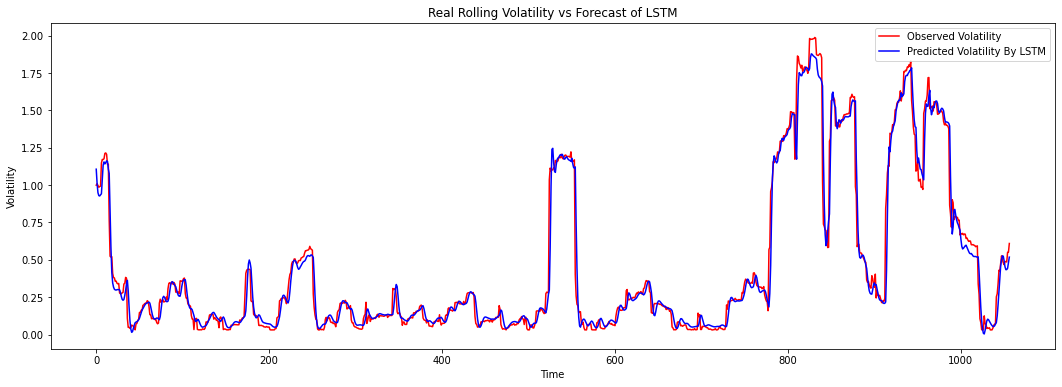

Root Mean Squared Error of the model is calculated as  0.9898876288527234


In [22]:
#scaler = MinMaxScaler(feature_range=(0,1))
#df_eth = scaler.fit_transform(df_eth)
training_set = df_eth.iloc[:, 10:11].values
# Create a data structure with 100 timestep and 1 output
X_train = []
y_train = []
for i in range(300, df_eth.shape[0]):
    X_train.append(training_set[i-300:i,0])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)


# In[24]:


X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


# In[25]:




# In[65]:


# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10))
regressor.add(Dropout(0.1))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

regressor.summary()

# In[66]:


regressor.save('my_modelp1.h5')
 

# In[27]:


from keras.models import load_model
regressor = load_model('my_modelp1.h5')


predicted_stock_price = regressor.predict(X_train)



# Visualising the results
plt.figure(figsize=(18,6))
plt.plot(df_eth.iloc[300:, 10:11].values, color = 'red', label = 'Observed Volatility')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Volatility By LSTM')
plt.title('Real Rolling Volatility vs Forecast of LSTM')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()


skor2 = rmse_tr(predicted_stock_price, np.array(df_eth.loc[df_eth.index[300:], 'Volatility']))
print("Root Mean Squared Error of the model is calculated as ",skor2)



In [23]:
training_set = df_eth.iloc[:, 10:12].values
# Create a data structure with 100 timestep and 1 output
X_train = []
y_train = []
for i in range(300, df_eth.shape[0]):
    X_train.append(training_set[i-300:i,:])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [24]:
df_eth.iloc[:, 10:12]

,forecast_vol
1052,0.476513
1053,0.436750
1054,0.461009
1055,0.980836
1056,1.169142
...,...
2404,0.489116
2405,0.485429
2406,0.550005
2407,0.551096


In [25]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))     ##Did 1 instead of 2


In [26]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 1))) #,1 instead of ,2 in the end)
regressor.add(Dropout(0.1))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10))
regressor.add(Dropout(0.1))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)



Epoch 1/100
34/34 [==============================] - 36s 821ms/step - loss: 0.2433
Epoch 2/100
34/34 [==============================] - 14s 413ms/step - loss: 0.1153
Epoch 3/100
34/34 [==============================] - 14s 410ms/step - loss: 0.0880
Epoch 4/100
34/34 [==============================] - 14s 404ms/step - loss: 0.0745
Epoch 5/100
34/34 [==============================] - 14s 411ms/step - loss: 0.0672
Epoch 6/100
34/34 [==============================] - 13s 395ms/step - loss: 0.0660
Epoch 7/100
34/34 [==============================] - 14s 414ms/step - loss: 0.0627
Epoch 8/100
34/34 [==============================] - 14s 421ms/step - loss: 0.0603
Epoch 9/100
34/34 [==============================] - 13s 393ms/step - loss: 0.0560
Epoch 10/100
34/34 [==============================] - 14s 401ms/step - loss: 0.0607
Epoch 11/100
34/34 [==============================] - 14s 407ms/step - loss: 0.0571
Epoch 12/100
34/34 [==============================] - 13s 388ms/step - loss: 0.0498
E

In [27]:
regressor.save('my_modelp2.h5')
from keras.models import load_model
regressor = load_model('my_modelp2.h5')

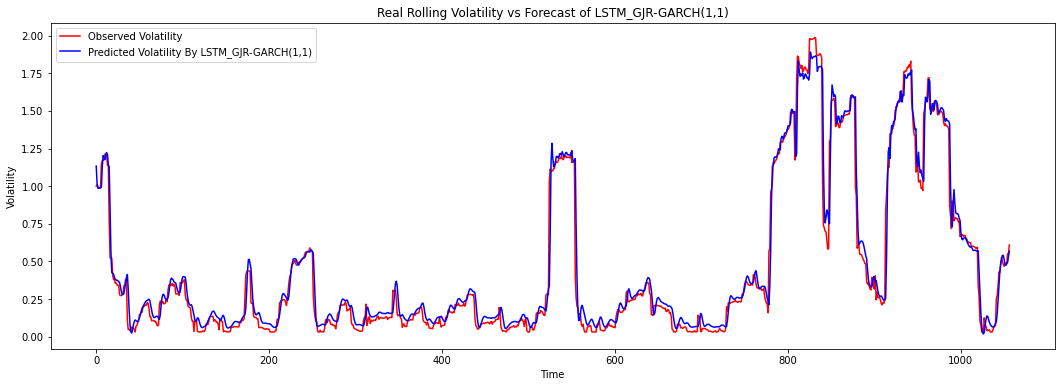

In [28]:
predicted_stock_price = regressor.predict(X_train)


plt.figure(figsize=(18,6))
plt.plot(df_eth.iloc[300:, 10:11].values, color = 'red', label = 'Observed Volatility')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Volatility By LSTM_GJR-GARCH(1,1)')
plt.title('Real Rolling Volatility vs Forecast of LSTM_GJR-GARCH(1,1)')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [29]:
skor3 = rmse_tr(predicted_stock_price, np.array(df_eth.loc[df_eth.index[300:], 'Volatility']))
print("Root Mean Squared Error of the model is calculated as ", skor3)

Root Mean Squared Error of the model is calculated as  0.9743041152791169


#Data exploration - Trends

In [11]:
df_eth['30days_close'] = df_eth['Close'].rolling(window = 30, min_periods = 0).mean()
df_xrp['30days_close'] = df_xrp['Close'].rolling(window = 30, min_periods = 0).mean()
df_iota['30days_close'] = df_iota['Close'].rolling(window = 30, min_periods = 0).mean()
df_doge['30days_close'] = df_doge['Close'].rolling(window = 30, min_periods = 0).mean()
df_lite['30days_close'] = df_lite['Close'].rolling(window = 30, min_periods = 0).mean()


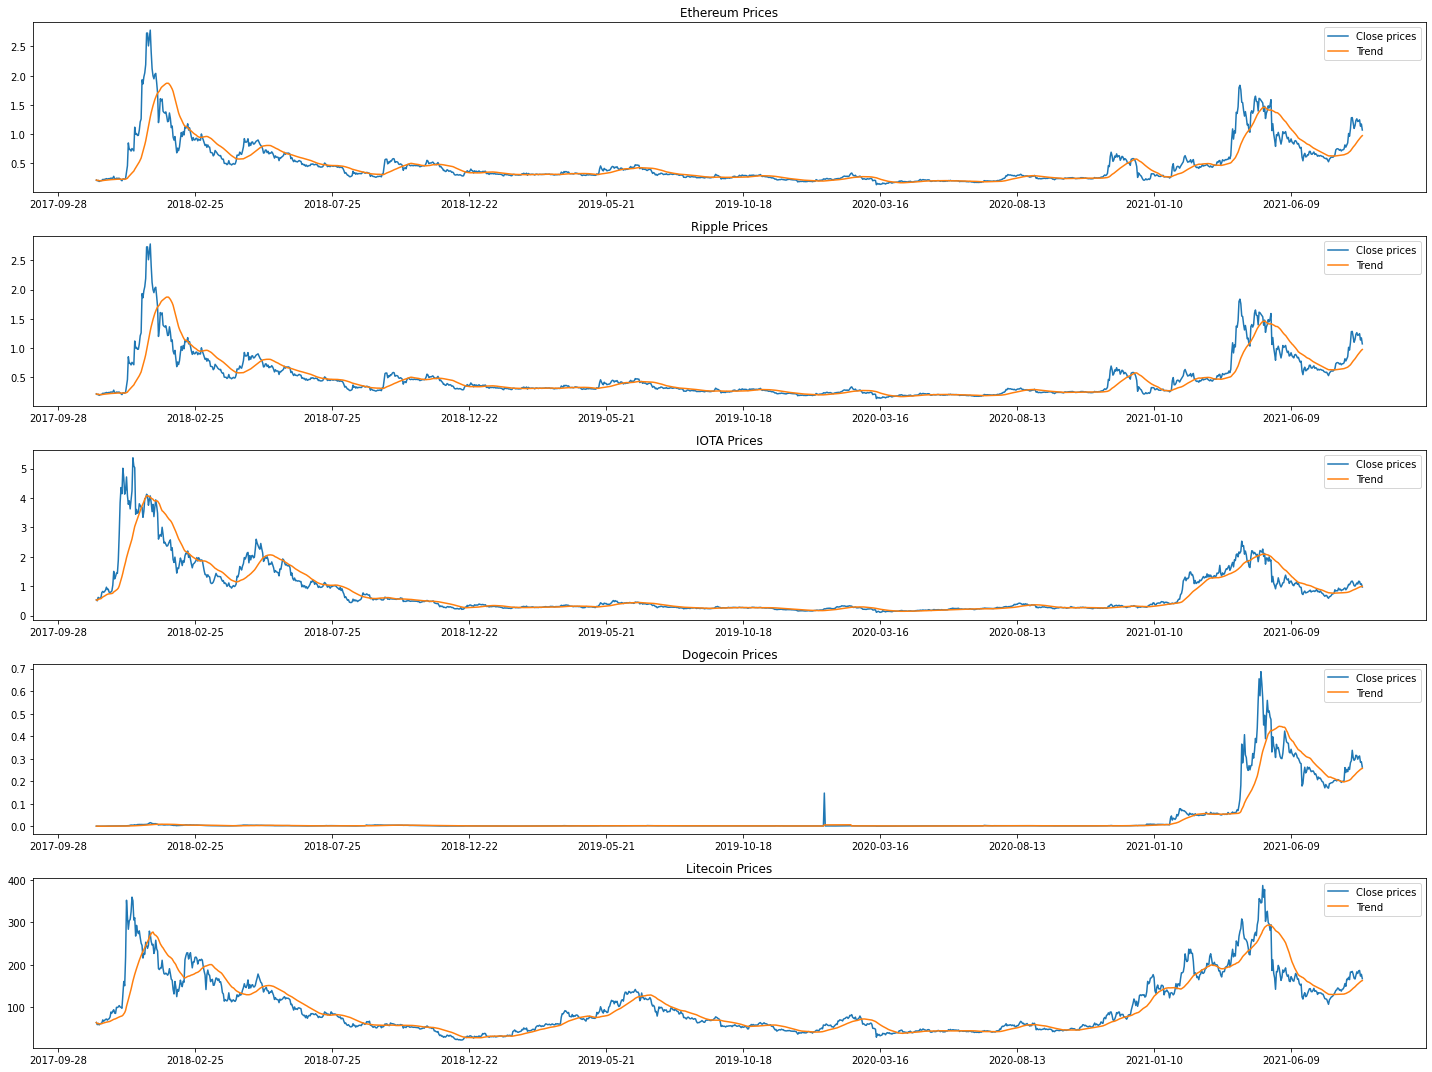

In [21]:
fig, ax = plt.subplots(5, 1, figsize=(20, 15))
ax[0].plot(df_eth.Date, df_eth.Close, label='Close prices')
ax[0].plot(df_eth.Date, df_eth['30days_close'],  label='Trend')
ax[0].xaxis.set_major_locator(plt.MaxNLocator(15)) # reduce number of x-labels
ax[0].set_title('Ethereum Prices')
ax[0].legend()

ax[1].plot(df_xrp.Date, df_xrp.Close, label='Close prices')
ax[1].plot(df_xrp.Date, df_xrp['30days_close'], label='Trend')
ax[1].xaxis.set_major_locator(plt.MaxNLocator(15)) # reduce number of x-labels
ax[1].set_title('Ripple Prices')
ax[1].legend()

ax[2].plot(df_iota.Date, df_iota.Close, label='Close prices')
ax[2].plot(df_iota.Date, df_iota['30days_close'], label='Trend')
ax[2].xaxis.set_major_locator(plt.MaxNLocator(15)) # reduce number of x-labels
ax[2].set_title('IOTA Prices')
ax[2].legend()

ax[3].plot(df_doge.Date, df_doge.Close, label='Close prices')
ax[3].plot(df_doge.Date, df_doge['30days_close'], label='Trend')
ax[3].xaxis.set_major_locator(plt.MaxNLocator(15)) # reduce number of x-labels
ax[3].set_title('Dogecoin Prices')
ax[3].legend()

ax[4].plot(df_lite.Date, df_lite.Close, label='Close prices')
ax[4].plot(df_lite.Date, df_lite['30days_close'], label='Trend')
ax[4].xaxis.set_major_locator(plt.MaxNLocator(15)) # reduce number of x-labels
ax[4].set_title('Litecoin Prices')
ax[4].legend()
#plt.grid()
plt.tight_layout()
plt.show()

We calculate the total value of its outstanding shares on the market, i.e. the market capitalisation.  Market capitalisation is an easy way for investors both to determine the size of a company and to try to assess the risk of investing in its shares.

In [26]:
df_eth['Total Traded'] = df_eth['Open']*df_eth['Volume']
df_xrp['Total Traded'] = df_xrp['Open']*df_xrp['Volume']
df_iota['Total Traded'] = df_iota['Open']*df_iota['Volume']
df_doge['Total Traded'] = df_doge['Open']*df_doge['Volume']
df_lite['Total Traded'] = df_lite['Open']*df_lite['Volume']


In [ ]:
df_eth['Total Traded']

In [36]:
mpld3.enable_notebook()

In [38]:
from mpld3 import plugins, utils


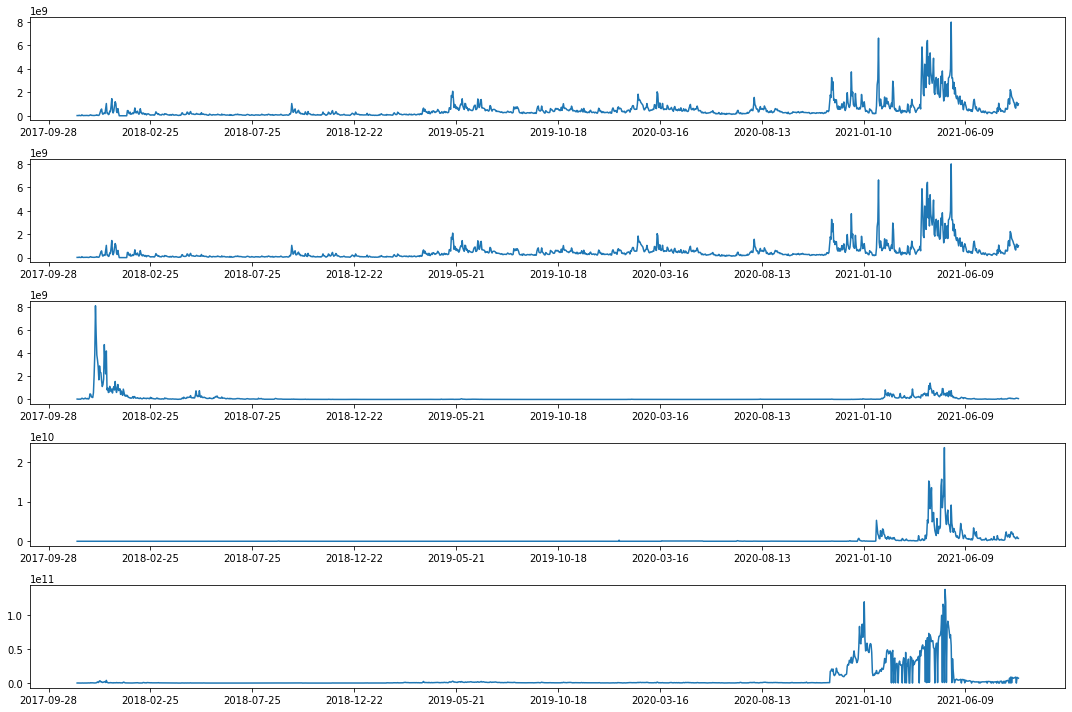

In [42]:
fig, ax = plt.subplots(5, 1, figsize=(15, 10))
ax[0].plot(df_eth.Date, df_eth['Total Traded'])
ax[0].xaxis.set_major_locator(plt.MaxNLocator(15)) # reduce number of x-labels
ax[1].plot(df_xrp.Date, df_xrp['Total Traded'])
ax[1].xaxis.set_major_locator(plt.MaxNLocator(15))
ax[2].plot(df_iota.Date, df_iota['Total Traded'])
ax[2].xaxis.set_major_locator(plt.MaxNLocator(15))
ax[3].plot(df_doge.Date, df_doge['Total Traded'])
ax[3].xaxis.set_major_locator(plt.MaxNLocator(15))
ax[4].plot(df_lite.Date, df_lite['Total Traded'])
ax[4].xaxis.set_major_locator(plt.MaxNLocator(15))
#plt.title('Total Traded')
plugins.connect(fig, plugins.MousePosition())

plt.tight_layout()
plt.show()



**Ethereum**<br>
We note that the highest peaks relate to the year 2021. Infact I found out in a article that around 13th Ethereum spiked (https://www.livemint.com/market/cryptocurrency/bitcoin-logs-over-800-jump-for-fy21-ethereum-zooms-1300-11617209720781.html)

"*Since October 2019, ethereum has been slowly but gradually stealing the market share from bitcoin. 
In a little more than 1.5 years, ethereum's dominance has gone from roughly 8% to 11.25%. The bulk of this market share can perhaps be attributed to the growth of various decentralized apps and crypto innovations on the ethereum blockchain, such as DeFi and NFTs*"


In [43]:
df_eth.iloc[df_eth['Total Traded'].argmax()]


Date            2021-05-19 00:00:00
Open                        1.59055
High                        1.64286
Low                         0.87542
Close                        1.0617
Volume                   5026776064
30days_close               1.408515
Total Traded        7995338668.5952
Name: 2309, dtype: object

**Ripple**<br>
In December last year, the SEC filed a lawsuit against Ripple, the company that created the cryptocurrency of the same name in 2012, and the legal proceedings are proceeding slowly.

At this stage, several legal skirmishes are taking place, sometimes in favour of Ripple and sometimes in favour of the SEC, such as in this particular case.

Therefore, although the price of XRP has risen almost fivefold since the beginning of the year, the news of the judge's decision against Ripple has thrown some pessimism into the mix, causing the price to fall.

This decision came on 19 May, the day of the flash crash in the crypto markets. However, while the price of bitcoin on that day fell from over $40,000$ to around $30,000$ and then rose again to $40,000$, the price of XRP fell from $1.60$ to $1.00$ and then only rose again to a little over $1.1$. 

(https://cryptonomist.ch/2021/05/21/sec-ripple-prezzo-xrp-in-calo/)


In [44]:
df_xrp.iloc[df_xrp['Total Traded'].argmax()]

Date            2021-05-19 00:00:00
Open                        1.59055
High                        1.64286
Low                         0.87542
Close                        1.0617
Volume                   5026776064
30days_close               1.408515
Total Traded        7995338668.5952
Name: 2309, dtype: object

**IOTA**<br>
"*The reason is the collaboration with Microsoft! In fact, the first public marketplace for IoT was launched last week, based in Berlin. IOTA has partnered with Microsoft, Fujitsu and twenty other companies (including Bosch and Accenture) to develop a solution for monetising data from Internet-connected devices. This marketplace will allow people to sell their data while remaining anonymous.
The idea behind IOTA is to allow any Internet-connected device to sell its data on an open marketplace that allows micro-payments. There are no specific applications yet, but according to the IOTA team this will be a new marketplace based on an innovative business model.*" (https://www.ilbitcoin.news/boom-iota-372-10-giorni/)

In [19]:
df_iota.iloc[df_iota['Total Traded'].argmax()]

Date            2017-12-06 00:00:00
Open                        3.81128
High                        5.54588
Low                         3.65532
Close                       4.35564
Volume                   2126969984
30days_close               1.227581
Total Traded      8106478186.421233
Name: 27, dtype: object

**Dogecoin**<br>
"*Yesterday, 9 May 2021, Geometric Energy Corporation (GEC) announced the first space mission fully funded by Dogecoin in partnership with SpaceX.*"


"*In addition to the transition, the two companies agreed that Dogecoin will be the official currency for all future GEC space missions. Dogecoin will therefore become the first official cryptocurrency for interplanetary trade. Samuel Reid, CEO of Geometric Energy Corporation commented: "After officially negotiating an agreement of this magnitude with DOGE, Geometric Energy Corporation and SpaceX have consolidated DOGE as the unit of account for lunar business in the space sector.*"

(https://www.astrospace.it/2021/05/10/spacex-e-geometric-energy-finanziano-una-missione-verso-la-luna-con-i-dogecoin/)

In [20]:
df_doge.iloc[df_doge['Total Traded'].argmax()]

Date            2021-05-09 00:00:00
Open                        0.63533
High                       0.697487
Low                        0.423602
Close                      0.568682
Volume                  37251653632
30days_close               0.334222
Total Traded     23667093102.018559
Name: 1436, dtype: object

In [21]:
df_lite.iloc[df_lite['Total Traded'].argmax()]

Date            2021-05-10 00:00:00
Open                        387.812
High                        412.802
Low                         335.177
Close                       359.106
Volume                    356903200
30days_close             284.004033
Total Traded    138411343798.399994
Name: 1720, dtype: object

I create a candlestick plot for Ethereum prices from April 2021 to July 2021

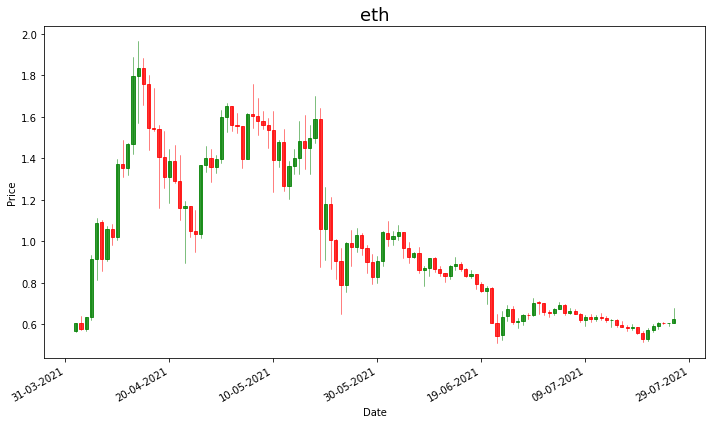

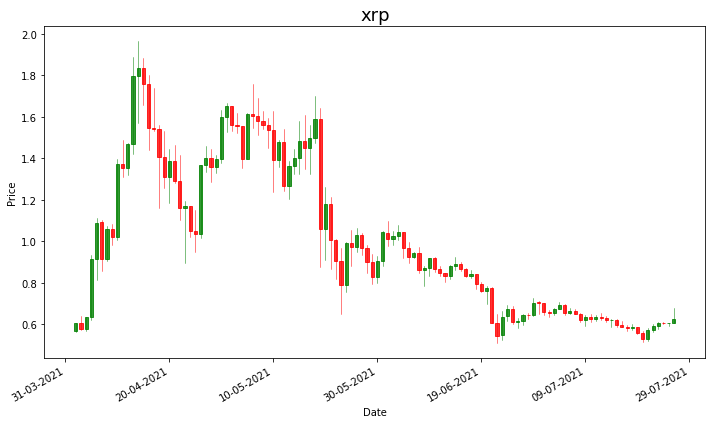

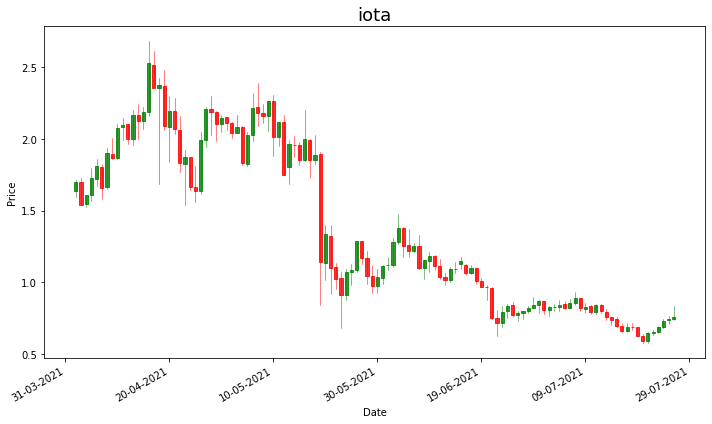

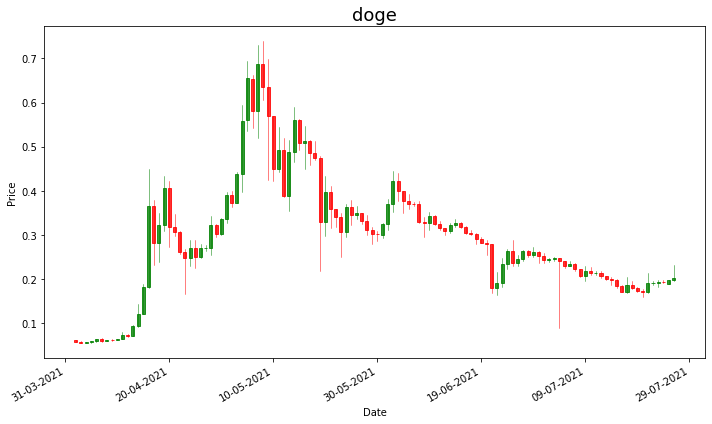

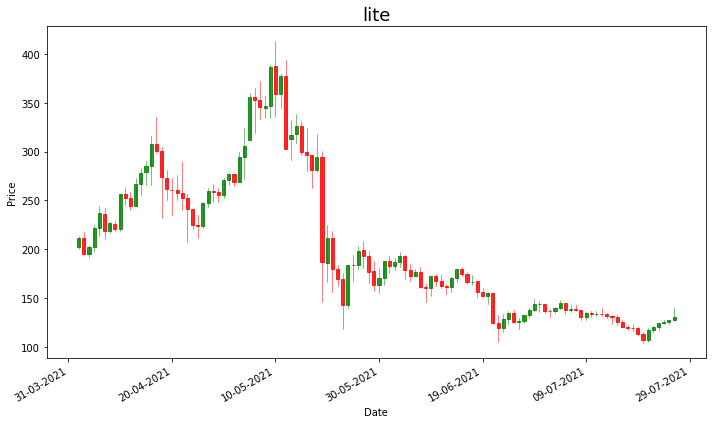

<Figure size 432x288 with 0 Axes>

In [22]:
def candlestick(df,title):
  ohlc = df[(df['Date'] > '2021-04-01') & (df['Date'] <= '2021-07-26')]
  ohlc = ohlc.loc[:, ['Date', 'Open', 'High', 'Low', 'Close']]
  ohlc['Date'] = pd.to_datetime(ohlc['Date'])
  ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
  ohlc = ohlc.astype(float)
  fig, ax = plt.subplots(figsize = (10,6))
  candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  date_format = mpl_dates.DateFormatter('%d-%m-%Y')
  ax.xaxis.set_major_formatter(date_format)
  ax.set_title(title, fontsize=18)
  fig.autofmt_xdate()
  fig.tight_layout()

a=candlestick(df=df_eth, title='eth')
b=candlestick(df=df_xrp, title='xrp')
c=candlestick(df=df_iota, title='iota')
d=candlestick(df=df_doge, title='doge')
e=candlestick(df=df_lite, title='lite')
#fig, axs = plt.subplots(5, 1, figsize=(20, 15))
ax[0]=a
ax[1]=b
ax[2]=c
ax[3]=d
ax[4]=e
plt.show()
plt.tight_layout()

Percentage change is a way to calculate the degree of change in a stock over a specific period of time using simple arithmetic. This metric is useful to investors, who use it to compare stocks with different price movements. 

\begin{align}
   r_{t}= \frac{p_{t}} {p_{t-1}} -1
  \end{align}

In the formula, ${p_{t}}$ denotes the price of an asset time $t$. Thus, $r_{t}$ is the profit rate of holding the asset from time $t-1$ to $t$.
From here we can define $r_{t}+1$ as the *one period gross return*, which is the ratio of the new market value at the end of the holding period over the initial market value. 

In [23]:
df_eth["Returns"] = (df_eth["Close"]/df_eth["Close"].shift(1)) - 1
df_xrp["Returns"] = (df_xrp["Close"]/df_xrp["Close"].shift(1)) - 1
df_iota["Returns"] = (df_iota["Close"]/df_iota["Close"].shift(1)) - 1
df_doge["Returns"] = (df_doge["Close"]/df_doge["Close"].shift(1)) - 1
df_lite["Returns"] = (df_lite["Close"]/df_lite["Close"].shift(1)) - 1


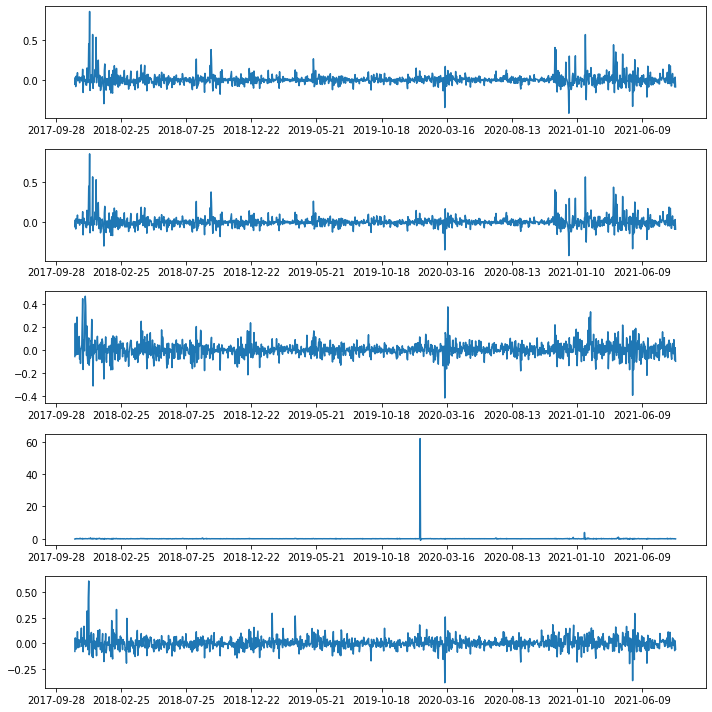

In [24]:
fig, ax = plt.subplots(5, 1, figsize=(10, 10))
ax[0].plot(df_eth.Date, df_eth['Returns'])
ax[0].xaxis.set_major_locator(plt.MaxNLocator(15)) # reduce number of x-labels
ax[1].plot(df_xrp.Date, df_xrp['Returns'])
ax[1].xaxis.set_major_locator(plt.MaxNLocator(15)) # reduce number of x-labels
ax[2].plot(df_iota.Date, df_iota['Returns'])
ax[2].xaxis.set_major_locator(plt.MaxNLocator(15)) # reduce number of x-labels
ax[3].plot(df_doge.Date, df_doge['Returns'])
ax[3].xaxis.set_major_locator(plt.MaxNLocator(15)) # reduce number of x-labels
ax[4].plot(df_lite.Date, df_lite['Returns'])
ax[4].xaxis.set_major_locator(plt.MaxNLocator(15)) # reduce number of x-labels
#plt.title('Returns')
plt.tight_layout()
#plt.grid()
plt.show()


The cumulative return is the total change in the investment price over a set time—an aggregate return, not an annualized one (https://www.investopedia.com/terms/c/cumulativereturn.asp#:~:text=The%20cumulative%20return%20is%20the,investment%20impacts%20its%20cumulative%20return).

\begin{align}
  c_{t}=(1+r_{t})c_{t-1}
      \end{align}

In [25]:
df_eth["Cumulative Return"] = (1 + df_eth["Returns"]).cumprod()
df_xrp["Cumulative Return"] = (1 + df_xrp["Returns"]).cumprod()
df_iota["Cumulative Return"] = (1 + df_iota["Returns"]).cumprod()
df_doge["Cumulative Return"] = (1 + df_doge["Returns"]).cumprod()
df_lite["Cumulative Return"] = (1 + df_lite["Returns"]).cumprod()


In [26]:
df_eth["Returns"].head()

1022         NaN
1023   -0.056175
1024    0.029021
1025   -0.084608
1026    0.044909
Name: Returns, dtype: float64

In [27]:
df_eth["Cumulative Return"].head()

1022         NaN
1023    0.943825
1024    0.971216
1025    0.889044
1026    0.928969
Name: Cumulative Return, dtype: float64

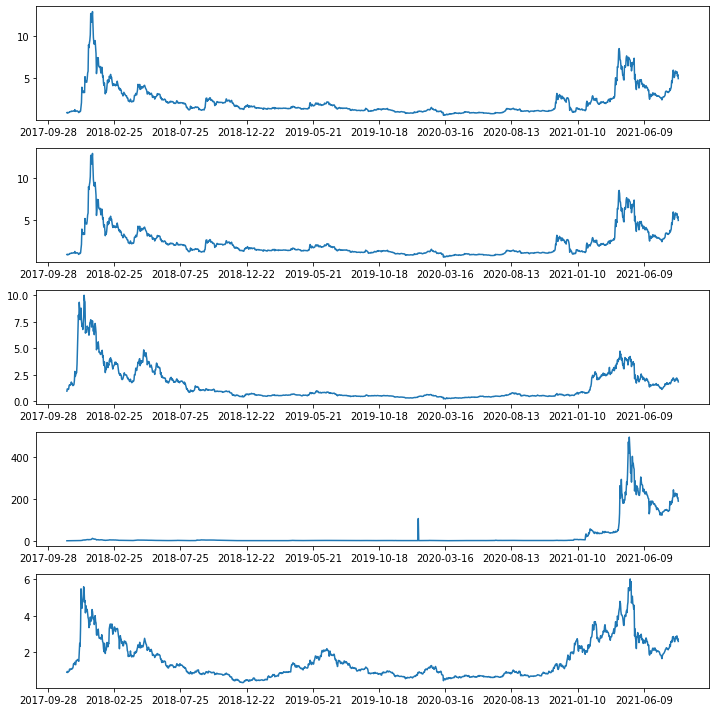

In [28]:
fig, ax = plt.subplots(5, 1, figsize=(10, 10))
ax[0].plot(df_eth.Date, df_eth['Cumulative Return'])
ax[0].xaxis.set_major_locator(plt.MaxNLocator(15)) # reduce number of x-labels
ax[1].plot(df_xrp.Date, df_xrp['Cumulative Return'])
ax[1].xaxis.set_major_locator(plt.MaxNLocator(15)) # reduce number of x-labels
ax[2].plot(df_iota.Date, df_iota['Cumulative Return'])
ax[2].xaxis.set_major_locator(plt.MaxNLocator(15)) # reduce number of x-labels
ax[3].plot(df_doge.Date, df_doge['Cumulative Return'])
ax[3].xaxis.set_major_locator(plt.MaxNLocator(15)) # reduce number of x-labels
ax[4].plot(df_lite.Date, df_lite['Cumulative Return'])
ax[4].xaxis.set_major_locator(plt.MaxNLocator(15)) # reduce number of x-labels
#plt.title('Returns')
plt.tight_layout()
#plt.grid()
plt.show()


#Drop na

In [30]:
df_eth.dropna(inplace=True)

In [31]:
df_xrp.dropna(inplace=True)
df_iota.dropna(inplace=True)
df_doge.dropna(inplace=True)
df_lite.dropna(inplace=True)

In [32]:
df_eth["Date"] = pd.to_datetime(df_eth["Date"])
df_eth["Year"] = df_eth["Date"].dt.year
df_eth["Month"] = df_eth["Date"].dt.month
df_eth["Day"] = df_eth["Date"].dt.day

In [33]:
tmp_df_eth = df_eth.groupby(["Date"])["Open","Close", "Volume", "Returns"].sum().reset_index()
tmp_df_eth["Volume"] = np.log(tmp_df_eth["Volume"])
tmp_df_eth["Diff"] = tmp_df_eth["Close"] - tmp_df_eth["Open"] 

tmp_df_eth


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Date,Open,Close,Volume,Returns,Diff
0,2017-11-10,0.21540,0.20330,18.367579,-0.056175,-0.01210
1,2017-11-11,0.20330,0.20920,18.153602,0.029021,0.00590
2,2017-11-12,0.20920,0.19150,19.175104,-0.084608,-0.01770
3,2017-11-13,0.19150,0.20010,18.224868,0.044909,0.00860
4,2017-11-14,0.20010,0.20500,17.902273,0.024488,0.00490
...,...,...,...,...,...,...
1381,2021-08-22,1.21654,1.22574,20.089788,0.007488,0.00920
1382,2021-08-23,1.22577,1.24617,20.648340,0.016667,0.02040
1383,2021-08-24,1.24630,1.13632,20.624879,-0.088150,-0.10998
1384,2021-08-25,1.13631,1.17436,20.457389,0.033476,0.03805


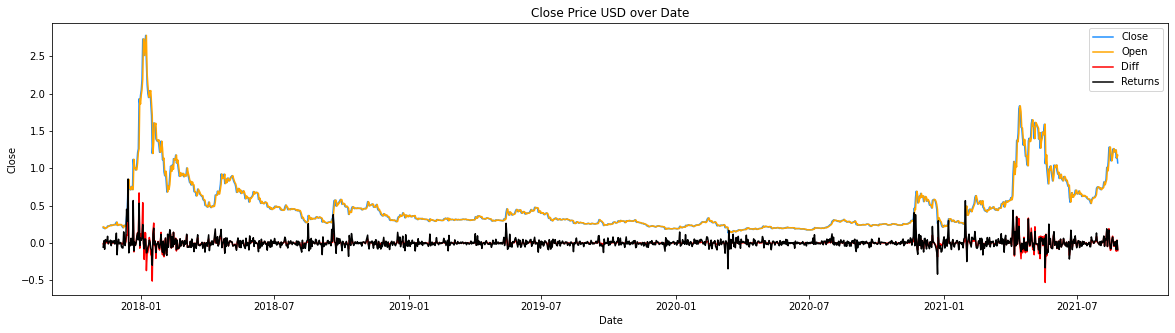

In [34]:
plt.figure(figsize=(20,5))
sns.lineplot(data=tmp_df_eth, x="Date", y="Close", color="dodgerblue", label="Close")
sns.lineplot(data=tmp_df_eth, x="Date", y="Open", color="orange", label="Open")
sns.lineplot(data=tmp_df_eth, x="Date", y="Diff", color="red", label="Diff")
sns.lineplot(data=tmp_df_eth, x="Date", y="Returns", color='black', label="Returns")
plt.title('Close Price USD over Date')
plt.legend()
plt.show();

#LSTM

In [35]:
def split_date(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    
split_date(df_eth)
split_date(df_xrp)
split_date(df_iota)
split_date(df_doge)
split_date(df_lite)

In [36]:

dataset_df_eth = df_eth[["Date", "Cumulative Return", "Volume", "Year", "Month", "Day"]]
dataset_df_xrp = df_xrp[["Date", "Cumulative Return", "Volume", "Year", "Month", "Day"]]
dataset_df_iota = df_iota[["Date", "Cumulative Return", "Volume", "Year", "Month", "Day"]]
dataset_df_doge = df_doge[["Date", "Cumulative Return", "Volume", "Year", "Month", "Day"]]
dataset_df_lite = df_lite[["Date", "Cumulative Return", "Volume", "Year", "Month", "Day"]]


In [37]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    data_x, data_y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
  
        if out_end_ix > len(sequence):
            break
        
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        data_x.append(seq_x[:,1:])
        data_y.append(seq_y[:,0])
    return np.array(data_x), np.array(data_y)

def model_score(model, X_train, y_train, X_test, y_test):
    train_score = model.evaluate(X_train, y_train, verbose=1)
    print("Train score: %0.5f MSE(%.2f RMSE)" % (train_score[0], math.sqrt(train_score[0])))
    test_score = model.evaluate(X_test, y_test, verbose=1)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (test_score[0], math.sqrt(test_score[0])))

    #print(metrics.classification_report())
def invTransform(scaler, data):
    dummy = pd.DataFrame(np.zeros((len(data), scaler.n_features_in_)))
    dummy[0] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=dummy.columns)
    return dummy[0].values


In [38]:
def LSTM_model(dataset, e, bs, lr):
    train_df = dataset[dataset['Date'] <= '2021'][['Cumulative Return', 'Date']].set_index('Date')
    test_df = dataset[dataset['Date'] > '2021'][['Cumulative Return', 'Date']].set_index('Date')
    plt.plot(train_df)
    plt.plot(test_df)
    plt.legend(['train', 'test'])
    plt.show()
    dataset.drop(["Date"], axis=1, inplace=True);

    TEST_PERCENT = len(test_df)/len(dataset)

    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = scaler.fit_transform(dataset)

    train_len = int(len(dataset) * (1-TEST_PERCENT))
    test_len = len(dataset) - train_len

    train = dataset[0:train_len]

    test = dataset[len(train):]

    n_steps_in, n_steps_out = 180, 1
    n_features = 4

    X_train, y_train = split_sequence(train, n_steps_in, n_steps_out)
    X_test, y_test = split_sequence(test, n_steps_in, n_steps_out)

    model_weight_file = "best_model.hdf_eth5"
    lr_reduce = ReduceLROnPlateau(monitor="val_loss", factor=0, min_delta=0.001, patience=1, verbose=1)
    checkpoint = ModelCheckpoint(model_weight_file, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    callbacks = [PlotLossesKerasTF(), es, checkpoint]

    model = Sequential()

    model.add(LSTM(256 , input_shape = (n_steps_in , n_features) , return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(256))
    model.add(Dropout(0.4))
    model.add(Dense(64 ,  activation = 'relu'))
    model.add(Dense(1))

    model.summary()


    model.compile(loss="mean_squared_error", 
                  optimizer=Adam(learning_rate=lr), 
                  metrics=["mean_squared_error"])

    EPOCHS = e
    BATCH_SIZE = bs

    history = model.fit(X_train, 
                        y_train, 
                        epochs = EPOCHS,
                        batch_size = BATCH_SIZE,
                        callbacks = callbacks, 
                        validation_data = (X_test,y_test))


    model_score(model, X_train, y_train, X_test, y_test)
    pred = model.predict(X_test)
    pred = invTransform(scaler, pred)
    pred[:10]
    pred_df = test_df.copy()
    pred_df[:-n_steps_in]["Cumulative Return"] = pred
    
    
    plt.rcParams["figure.figsize"] = (15,7)
    plt.plot(test_df["Cumulative Return"], 'b', label='Ethurem Series')
    plt.plot(pred_df["Cumulative Return"] , 'r', label='Predicted Ethurem Series')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Return')
    plt.title('Check the accuracy of the model with time')
    plt.grid(True)
    plt.legend()
    plt.show()
    #print(metrics.classification_report(test_df["Cumulative Return"] , pred_df["Cumulative Return"]))


#Tuning of parameters

In [39]:
epochs=20 #@param [20, 40]
batch_size=16 #@param [16, 32]
#learning rate as tuning parameter
learning_rate=0.0005 #@param [0.0005, 0.005, 0.05]

#Results

In [ ]:
# LSTM_model(dataset_df_eth, e=epochs, bs=batch_size, lr=learning_rate)

In [ ]:
# LSTM_model(dataset_df_xrp, e=epochs, bs=batch_size, lr=learning_rate)

In [ ]:
# LSTM_model(dataset_df_iota, e=epochs, bs=batch_size,  lr=learning_rate)

In [ ]:
# LSTM_model(dataset_df_doge, e=epochs, bs=batch_size,  lr=learning_rate)

In [ ]:
#LSTM_model(dataset_df_lite, e=epochs, bs=batch_size,  lr=learning_rate)

In [ ]:
# from sklearn.metrics import confusion_matrix
# from sklearn import metrics
# import seaborn as sns

# y_true = np.argmax(y_val , 1)
# y_pred = np.argmax(model.predict(x_val) , 1)
# print(metrics.classification_report(y_true , y_pred))

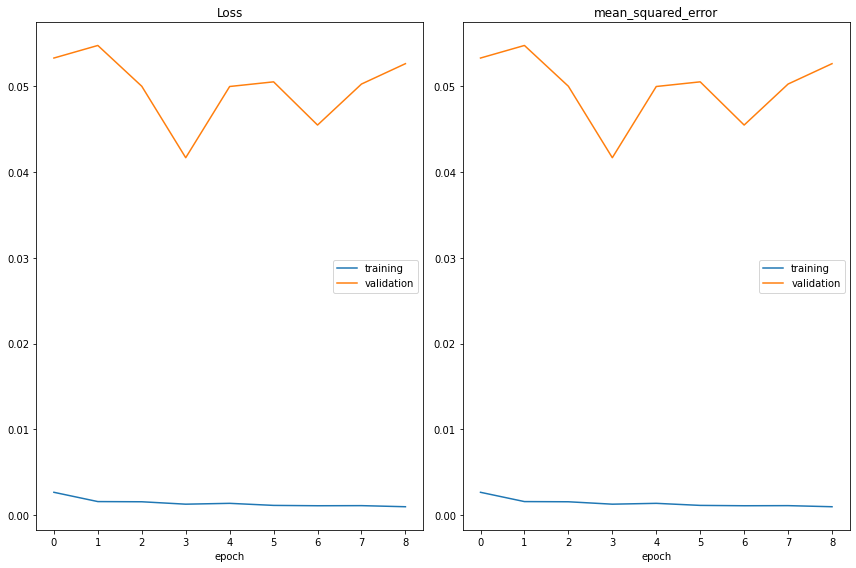

Loss
	training         	 (min:    0.001, max:    0.003, cur:    0.001)
	validation       	 (min:    0.042, max:    0.055, cur:    0.053)
mean_squared_error
	training         	 (min:    0.001, max:    0.003, cur:    0.001)
	validation       	 (min:    0.042, max:    0.055, cur:    0.053)

Epoch 9: val_loss did not improve from 0.04168
61/61 [==============================] - 68s 1s/step - loss: 9.8922e-04 - mean_squared_error: 9.8922e-04 - val_loss: 0.0526 - val_mean_squared_error: 0.0526
Epoch 9: early stopping
31/31 [==============================] - 12s 375ms/step - loss: 8.3090e-04 - mean_squared_error: 8.3090e-04
Train score: 0.00083 MSE(0.03 RMSE)
2/2 [==============================] - 1s 284ms/step - loss: 0.0526 - mean_squared_error: 0.0526
Test Score: 0.05264 MSE (0.23 RMSE)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


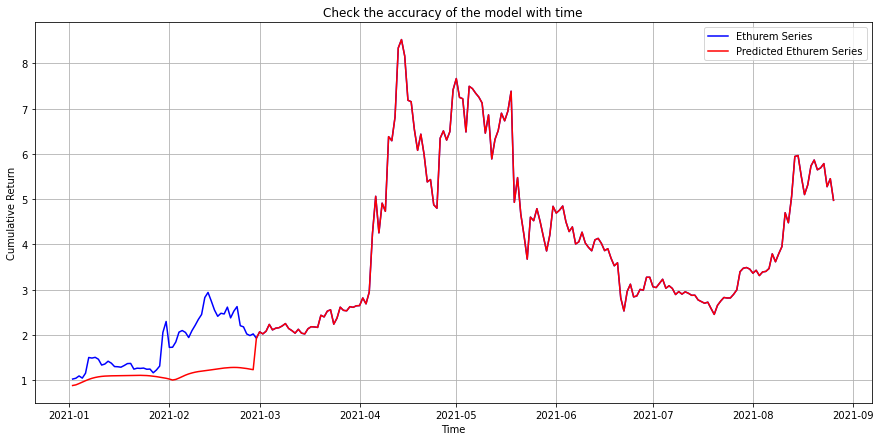

In [40]:
# train_df = dataset_df_eth[dataset_df_eth['Date'] <= '2021'][['Cumulative Return', 'Date']].set_index('Date')
# test_df = dataset_df_eth[dataset_df_eth['Date'] > '2021'][['Cumulative Return', 'Date']].set_index('Date')
# plt.plot(train_df)
# plt.plot(test_df)
# plt.legend(['train', 'test'])
# plt.show()
# dataset_df_eth.drop(["Date"], axis=1, inplace=True);

# TEST_PERCENT = len(test_df)/len(dataset_df_eth)

# scaler = MinMaxScaler(feature_range=(0,1))
# dataset = scaler.fit_transform(dataset_df_eth)

# train_len = int(len(dataset) * (1-TEST_PERCENT))
# test_len = len(dataset) - train_len

# train = dataset[0:train_len]

# test = dataset[len(train):]

# n_steps_in, n_steps_out = 180, 1
# n_features = 4

# X_train, y_train = split_sequence(train, n_steps_in, n_steps_out)
# X_test, y_test = split_sequence(test, n_steps_in, n_steps_out)

# model_weight_file = "best_model.hdf_eth5"
# lr_reduce = ReduceLROnPlateau(monitor="val_loss", factor=0, min_delta=0.001, patience=1, verbose=1)
# checkpoint = ModelCheckpoint(model_weight_file, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# callbacks = [PlotLossesKerasTF(), es, checkpoint]

# model = Sequential()

# model.add(LSTM(256 , input_shape = (n_steps_in , n_features) , return_sequences=True))
# model.add(Dropout(0.4))
# model.add(LSTM(256))
# model.add(Dropout(0.4))
# model.add(Dense(64 ,  activation = 'relu'))
# model.add(Dense(1))

# model.summary()


# model.compile(loss="mean_squared_error", 
#               optimizer=Adam(learning_rate=learning_rate), 
#               metrics=["mean_squared_error"])

# EPOCHS = epochs
# BATCH_SIZE = batch_size

# history = model.fit(X_train, 
#                     y_train, 
#                     epochs = EPOCHS,
#                     batch_size = BATCH_SIZE,
#                     callbacks = callbacks, 
#                     validation_data = (X_test,y_test))


# model_score(model, X_train, y_train, X_test, y_test)
# pred = model.predict(X_test)
# pred = invTransform(scaler, pred)
# pred[:10]
# pred_df = test_df.copy()
# pred_df[:-n_steps_in]["Cumulative Return"] = pred
    
    
# plt.rcParams["figure.figsize"] = (15,7)
# plt.plot(test_df["Cumulative Return"], 'b', label='Ethurem Series')
# plt.plot(pred_df["Cumulative Return"] , 'r', label='Predicted Ethurem Series')
# plt.xlabel('Time')
# plt.ylabel('Cumulative Return')
# plt.title('Check the accuracy of the model with time')
# plt.grid(True)
# plt.legend()
# plt.show()
